# From model to utility-function-gradient

In this notebook we follow the path from a user-provided test problem (steady state advection diffusion equation), over how measurements are taken along a path characterized by flight path parameters `alpha`, to the utility function and its gradient. The main purpose of this notebook is to check that
1. after changing the source class structure, everything still works
2. the gradient computation still works after its code is put from its model specific form into the general source code
3. show how to use the main source functions for use in the `Optimization` class

## Imports

In [1]:
import sys
sys.path.insert(0, "../source/")
sys.path.insert(0, "../models/AdvectionDiffusion/settings/AdvectionDiffusion_FEniCS")
sys.path.insert(0, "../models/AdvectionDiffusion/Navigators")
sys.path.insert(0, "../models/AdvectionDiffusion/Detectors")

# %load_ext autoreload
# %autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

from InverseProblem import InverseProblem
from FOM_stationary import FOM_stationary as FOM
from Drone import Drone as Drone
from DetectorPointwise import DetectorPointwise as Detector
from NavigationCircle import NavigationCircle as Navigation
from OEDUtility import OEDUtility

import time
tStart_notebook = time.time()

## User settings
These are the easiest changes a user might want to make when running the notebook. Changes to the code blocks below should ideally not be necessary.

In [2]:
centers = [[0.35, 0.7], [0.8, 0.2], [0.7, 0.5], [0.1, 0.9], [0.1, 0.2]]
var_prior = 1 # set to a high value (1e+6) to test convergence in noise-free situations

n_test = 40 # resolution for 1D plots
n_test_2d = 10 # resolution for 2D plots (50: ~1 min runtime for dt = 0.01)

## Full-order model setup

First we initialize the full-order model [FOM]. The model is user-specific, but we have imported it here under the name `FOM` such that we can switch out models easily by changing the import statement only (as long as there are no model-specific settings we also need to make).

In [3]:
tStart = time.time()
fom = FOM(centers=centers)
print("Runtime of this block: {} s".format(time.time()-tStart))

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FF

**Note:** If the FOM is not cached, then it takes a little bit to set up since the initialization here, since it includes the assembly of mass and stiffness matrix, and the solve (stationary Navier Stokes) for the velocity field. For fine meshes, this make take some time.

For a given parameter, we can solve the model with a call to `solve`. `solve` is a call any `FullOrderModel` subclass has to have.

In [4]:
n_para = fom.n_para
para_true = np.ones((n_para,))

tStart = time.time()
state = fom.solve(parameter=para_true)
print("FOM solve time: {} s.".format(time.time()-tStart))

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
FOM solve time: 53.959801197052 s.


In contrast, we don't require `FullOrderModel` to have a plot function. However, since it's useful to look at the state and we have a plot function for our example model, it doesn't hurt to take a look:

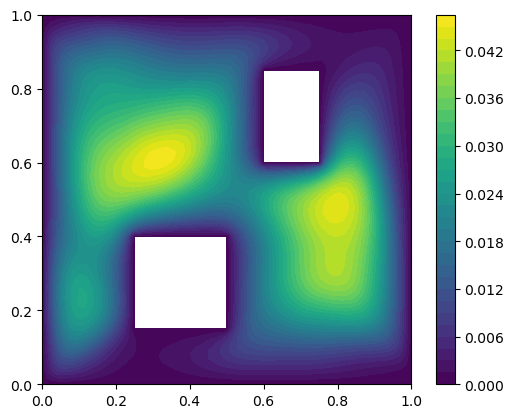

In [5]:
fom.plot(state)

By the way, the output of `fom.solve` is a `State`-object. Using a `State` object makes it easier for us to pass information around. Only the full-order model and the drone need to know how to interact with the state, and all of those are user-defined, so the `State` class makes it easier for the user to keep all the information related to a specific model solve.

## Prior

In our discussion we said we wanted the prior to be a part of the `FullOrderModel` class. I'm not entirely sure I like that, I think one could make an argument for keeping it separate, in particular once we go into parameter space reduction. For now it's part of it though, so stop whining.

Before we can even think of solving a Bayesian inverse problem, we need to specify a prior. It's assumed to be a Gaussian, which is uniquely specified by its mean and covariance matrix. For our example here we set the prior to be iid, centered around 0.

We have decided to make the prior part of our FOM for now. If we go towards parameter space reduction, this is likely to change, but for now we keep it this way.

In [6]:
# user setting options
prior_mean = np.zeros((n_para,))  # prior mean: 1D np.ndarray with n_para entries
prior_covar = var_prior*np.eye(n_para)  # prior covariance matrix: symmetric positive definite matrix

# inform FOM about the prior
fom.set_prior(prior_mean=prior_mean, prior_covar=prior_covar)

We can sample the prior by calling `fom.sample`, though for our OED problem we won't need this until we go into parameter space reduction:

In [7]:
fom.sample(n_samples = 2)

array([[ 1.63240137,  1.29143861],
       [ 1.65139392,  0.13433381],
       [ 1.40834164, -0.75974711],
       [-0.23094498, -1.59874056],
       [ 0.69353773,  1.3696697 ]])

## Drone

The drone is also user-defined, for two main reasons:
- it needs to interact with the state, which depends on the full-order model, and hence on the FE solver (or whichever discretization is used). We can therefore not specifiy a uniform way to interact with the state
- the parameterization of the flight path is model dependent

The `Drone` has two parts:
- **Navigation:** the code part that characterizes how a drone may (or may not fly), i.e. the connection between the flight's trajectory and the control parameters. This code includes the derivative of the flight path with respect to the control parameters too. Here, we have imported `NavigationCircle` as `Navigation`, such that the drone's path is only characterized by two parameters: radius and speed.
- **Detector:** how the drone measures. We have implemented several options (see notebook `2_measurement_types`), but eventually it is up to the application at hand how the measurements should be modelled. Here we've imported `DetectorPointwise` as `Detector` which uses pointwise measurements.

We have made these import choices to keep this notebook fast with plots that can easily be interpreted. We show more complicated scenarios in later notebooks.

While `navigation` and `detector` are user specific, the `drone` object, which is the interface between them and the rest of the environment, can be imported straight from the source code without individualization. 

We are still keeping it as an object in the middle though just in case `navigation` and `detector` need to talk to each other, and so that the other classes don't need to know the specifics about how to distinguish between them. 

In [8]:
navigation = Navigation()
detector = Detector(fom)

drone = Drone(detector=detector, navigation=navigation)

The flightpath is parameterized using the "control" `alpha`. For our example here, `alpha = [radius, speed]`. Any `Drone` object has to have the function `plan_flight` which returns the `Flight` object for a given flight path parameterization `alpha`. The `flight` stores all `alpha`-specific information, like the time discretization and the flightpath it is going to take.

In [9]:
# user setting (for trying out different controls)
alpha = np.array([0.25, 0.2])

# compute flight
flight = drone.plan_flight(alpha=alpha)  # Flight object
flightpath, grid_t_drone = flight.flightpath, flight.grid_t  # path and its time discretization

For our case here we can easily plot the flight path:

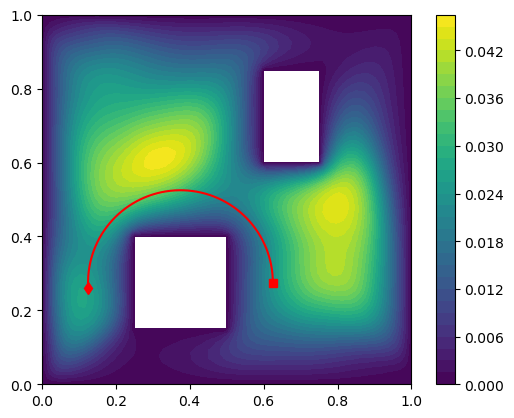

In [10]:
fom.plot(state)
plt.plot(flightpath[:, 0], flightpath[:, 1], color="r")
plt.plot([flightpath[0, 0]], [flightpath[0, 1]], color="r", marker="s")
plt.plot([flightpath[-1, 0]], [flightpath[-1, 1]], color="r", marker="d")

Another function every `Drone` subclass has to have implemented is `measure`:

In [11]:
measurements = drone.measure(state=state, flight=flight)

A measurement is computed for given `Flight` and `State`. If we don't have the `flight`, the detector doesn't know along which path to measure. If `state` is missing, then it doesn't know what to measure. Beyond those, nothing should need to be passed - any individual measurement settings should be made on the `detector` level.

Text(0.5, 1.0, 'point-wise measurement along flightpath')

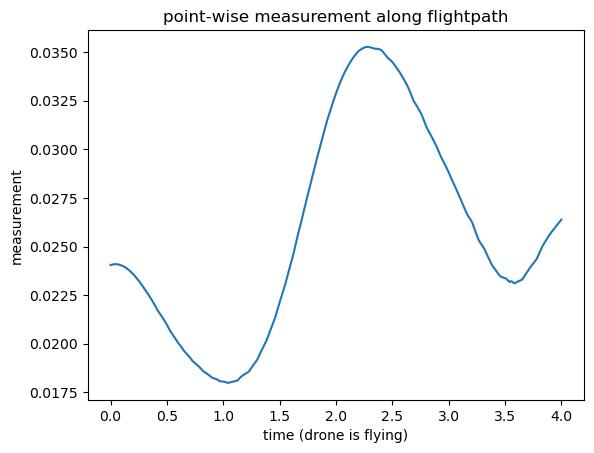

In [12]:
fig, ax = plt.subplots(1,1)
ax.plot(grid_t_drone, measurements)
ax.set_xlabel("time (drone is flying)")
ax.set_ylabel("measurement")
ax.set_title("point-wise measurement along flightpath")

## Inverse Problem

We now come to the classes that are no longer user-dependent. The first one is `InverseProblem`. It should function regardless of what the forward model is.

`InverseProblem` needs to know the forward model, especially since it contains the prior currently, and the drone. `InverseProblem` is the class that generates the posterior distribution for a given flightpath as one of its outputs, therefore it doesn't get a fixed flight path in its initialization

In [13]:
inversion = InverseProblem(fom, drone)

We precompute the states for a linear combination of parameter basis vectors. For now we use the unit basis, we'll take a closer look at other bases later in the context of parameter space reduction:

In [14]:
tStart = time.time()
inversion.compute_states(np.eye(n_para))
print("State solve time ({} parameters): {} s".format(n_para, time.time()-tStart))

Calling FFC just-in-time (JIT) compiler, this may take some time.
State solve time (5 parameters): 262.24919295310974 s


For curiosity and mental health, let's take a look at the states we've gotten for this basis:

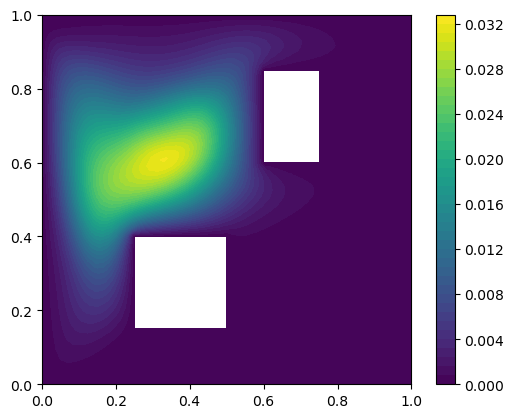

In [15]:
i = 0  # change i = 1, ..., n_para

fom.plot(inversion.states[i])

Beautiful.

**TODO:** For optimizing the inverse problem, we'll probably want to oursource some computations to, e.g., `hIppylib`. I have not done that yet. 

## Posterior distribution

For a given `flight` and measurement data along its path, the `InverseProblem` can generate a posterior distribution for us. For each `flight`, we get a different posterior.

If no measurement data is provided, we can still create an object that handles the "posterior" covariance matrix for us. Note that under our linearity assuptions the posterior covariance matrix is data-independent.

**Note:** `InverseProblem` is potentially a misnomer. Why? (Nicole, April 1, 2024)

In [16]:
posterior = inversion.compute_posterior(alpha = alpha)

If a `flight` was already computed for `alpha`, it should be provided to avoid duplicates and confusion. 

In [17]:
posterior = inversion.compute_posterior(flight=flight)

**Note:** Since `compute_posterior` can work with both `flight` and `alpha` as input, make sure to tell it which one is used to avoid errors.

Let's take a look at the posterior mean. Remember that our prior was centered around 0, and our "true" parameter (the one from which we got the data), has 1's everywhere.

In [18]:
posterior.compute_mean(data=measurements)

array([0.68399761, 0.29000185, 0.15971269, 0.23967451, 0.130556  ])

With more trust in the data (increase `c_scaling` in `InverseProblem`) or less trust in the prior (increase the scaling factor when defining the prior covariance matrix) we see that we indeed converge to the true solution (we didn't apply any noise and have lots of measurements, so that's expected).

We could plot the marginal distribution but for now I think it's ok.

## OED utility function
Time to judge how good our flight path really is. The utility function draws its main information from the inversion.

**TODO:** actually, I don't think `OEDUtility` interacts with anything but the posterior at which it is asked to compute something. I don't think it even needs to be a class but just a collection of functions. I'm keeping it anyway since it makes structural sense and might get more functions in the future.

In [19]:
utility = OEDUtility(inversion)

For any flightpath characterization `alpha`, we can evaluate the utility of its associated flightpath by computing the utility function of the posterior covariance matrix.

**Note:** Again an example in favor of introducing a `Flightpath` class. For a given `alpha` we'd instantiate this class, and if needed it would then compute the posterior for us. The way it's implemented currently we pass the posterior around sepparately from `alpha`, which is just super prone to errors.

In [20]:
# user setting: control parameter
alpha = np.array([0.25, 0.2])

# compute posterior
posterior = inversion.compute_posterior(alpha=alpha)

print("A-OED:", utility.eval_utility(posterior, mode="A"))
print("D-OED:", utility.eval_utility(posterior, mode="D"))
print("E-OED:", utility.eval_utility(posterior, mode="E"))

A-OED: 4.191722597965532
D-OED: 0.3558667280330201
E-OED: 0.9998461547728921


For comparison, for the prior we have:

In [21]:
print("A-OED (prior):", np.trace(fom.prior_covar))
print("D-OED (prior):", la.det(fom.prior_covar))
print("E-OED (prior):", np.max(la.eigh(fom.prior_covar)[0]))

A-OED (prior): 5.0
D-OED (prior): 1.0
E-OED (prior): 1.0


To get a feeling for the three functions, let's plot them over our control domain for alpha. First, we need to figure out the admissible domain. We don't want the drone to collide with the boundary of the domain (restriction on the radius). The speed is - theoretically - unrestricted. However, I'm not entirely sure if, when we repeat locations, this would change our noise covariance or if we can just treat them as if there was no overlap. This is only a question for the stationary problem of course.

Until I've figured this out I restrict the maximum speed such that, for minimial radius, the drone will fly at most one circle but not start on a second.

In [22]:
# admissible domain
radius_min = la.norm(np.array([0.75, 0.55])/2 - np.array([0.5, 0.4])) # 0.1767
radius_max = la.norm(np.array([0, 0.55])/2) # 0.275
# drone may not collide with buildings or leave the domain

final_time = grid_t_drone[-1]
speed_max = 2 * np.pi * radius_min / final_time
# maximum speed is chosen such that go for at most one circle

Theoretically we could re-visit measurement locations. I need to think about what that means for the noise model though.

Now we compute the OED-utility values for all combinations of radius and speed:

In [23]:
tStart = time.time()

# grid over admissible domain
vec_speed_2d = np.linspace(0.05 * speed_max, speed_max, n_test_2d)
vec_radius_2d = np.linspace(radius_min, radius_max, n_test_2d+1)

vec_speed = np.linspace(0.05 * speed_max, speed_max, n_test)
vec_radius = np.linspace(radius_min, radius_max, n_test+1)
# note: I'm not making the vectors the same lengths so I don't accidentally confuse the directions

# initialize
util = np.zeros((3, n_test_2d+1, n_test_2d))

for i in range(n_test_2d+1):
    for j in range(n_test_2d):
        
        alpha = np.array([vec_radius_2d[i], vec_speed_2d[j]])
        posterior = inversion.compute_posterior(alpha=alpha)
        
        util[0, i, j] = utility.eval_utility(posterior, mode="A")
        util[1, i, j] = utility.eval_utility(posterior, mode="D")
        util[2, i, j] = utility.eval_utility(posterior, mode="E")
        
print("Runtime of this block: ", (time.time()-tStart)/60, "min.")

Runtime of this block:  0.04190656741460164 min.


Finally we can plot the OED-utility. A- and D-OED look fairly similar, E-OED has almost a shock-like behavior. This is because if the drone isn't fast enough for its radius, it will never reach the areas of the state that are influenced by the 5th forcing function. In this case, the uncertainty for the 5th parameter entry will not get reduced, i.e., at least one eigenvalue will remain unchanged when updating the prior. Since the prior was chosen iid., the maximum eigenvalue of the posterior is then the same as the prior. The E-OED utility function will remain constant until the combination of speed and radius is able to detect all forcing functions. At this point the uncertainty in all directions improves and the E-OED utility begins to improve.

Text(0.5, 1.0, 'E-OED')

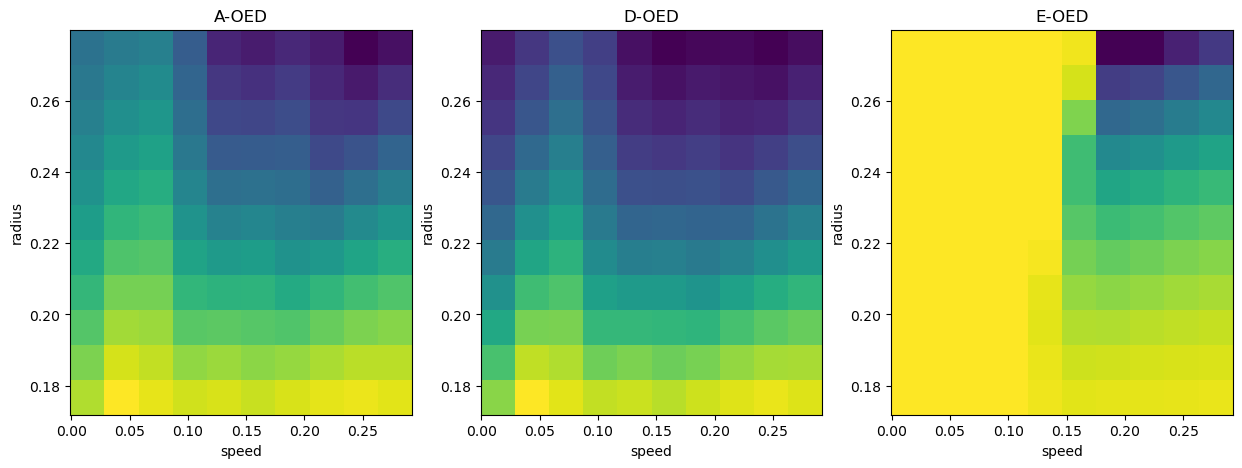

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i in range(3):
    axs[i].pcolormesh(vec_speed_2d, vec_radius_2d, util[i, :, :])
    axs[i].set_xlabel("speed")
    axs[i].set_ylabel("radius")
    
axs[0].set_title("A-OED")
axs[1].set_title("D-OED")
axs[2].set_title("E-OED")

## Derivative of the utility function

### derivative of the position
We take a quick look at the derivatives of the position, because there's an interesting observation to be made (spoiler!). It's also good for double-checking and getting an idea for how the derivatives behave in time.

In [25]:
der_all = flight.d_position_d_control

The derivative returned by `flight.d_position_d_control` has shape `<n_spatial>*<n_timesteps>` $\times$ `<n_controls>` because the spatial position of the _whole_ flight is determined by `<n_spatial>*<n_timesteps>` parameters (at each time step, there are `n_spatial` directions). `flight.d_position_d_control` is ordered by spatial direction, i.e. the first `n_timesteps` entries are for the x-direction, the next `n_timesteps` for the y-direction, etc. If we want the directional derivative at a single point in time, we need to re-order.

In [26]:
reordered = np.zeros((navigation.n_timesteps, navigation.n_spatial, navigation.n_controls))

for m in range(navigation.n_controls):
    reordered[:, :, m] = np.reshape(der_all[:, m], (navigation.n_timesteps, navigation.n_spatial), order = "F")

der_all = reordered

After re-ordering, `der_all[k, :, :]` has in its columnss the derivatives of the position $p(t_k) \in \mathbb{R}^{2}$ w.r.t. the radius (first column) and the speed (second column).

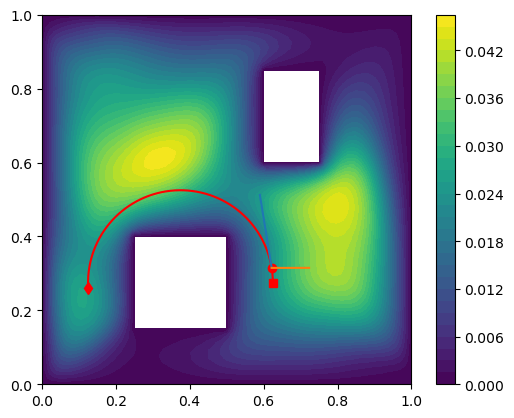

In [27]:
t = 0.2
k = np.argmin(np.abs(grid_t_drone - t))
der = der_all[k, :, :]
pos = flight.flightpath

der_radius = der[:, 0]
der_speed = der[:, 1]

fom.plot(state)
plt.plot(pos[:, 0], pos[:, 1], color="r")
plt.plot([pos[k, 0]], [pos[k, 1]], marker = "o", color = "r")
plt.plot([pos[0, 0]], [pos[0, 1]], color="r", marker="s")
plt.plot([pos[-1, 0]], [pos[-1, 1]], color="r", marker="d")

plt.plot([pos[k, 0], pos[k, 0] + 1 * der_speed[0]], [pos[k, 1], pos[k, 1] +1 * der_speed[1]])  # speed
plt.plot([pos[k, 0], pos[k, 0] + 0.1 * der_radius[0]], [pos[k, 1], pos[k, 1] + 0.1 * der_radius[1]])  # radius

Both derivatives are nice and interpretable close to `t=0`. The more time passes, the weirder the derivatives look. That's because the more time passes the more influence do the radius and the speed have on the position, and the derivatives can consequently be expected to become larger and larger (If this is not clear, think about the difference quotient). 

This observation might be important for us because since we are planning to puzzle the flightpath together from various curves. It might pose a limit on how long we can make each segment of the control in comparison to the time discretization of the drone. I need to think about this some more.

### Derivatives of the OED-utility function
We've arrived at the final stage - the derivatives of the OED-utility function! We get the derivatives from the `OEDUtility` class with the function `eval_utility`. To specify the position `alpha` at which we want to compute the derivative we pass the associated `Posterior` object. This is not quite intuitive. I think it makes more sense - also for avoiding unnecessary re-computations - to have a `Flightpath` object for each control parameter vector `alpha` that contains the flight path positions, time grid, and any attributes computed along the way like the derivatives. 

Note below that so far we only have the derivatives for A- and D-OED, as well as for "D-inverse" which is the determinant of the inverse posterior covariance matrix (instead of "D", the determinant of the posterior covariance matrix).

Feel free to change the values of `speed_test` and `radius_test` below. They specify where we evaluate the derivative. In addition, we compute the OED-utility function values along `vec_radius x {speed_test}` and `{radius_test} x vec_speed` to visualize whether the derivative is indeed correct.

**Note:**
For the optimization routine, the first part of this block (between `##`) is the most important, since it shows the calls the optimization routine will need to make.

In [28]:
# user input: Where to evaluate the derivative:
speed_test = 0.08 # choose value between 0 and max(vec_speed) \approx 0.27768018
radius_test = 0.22 # choose value between radius_min \approx 0.1767766952966369 and radius_max \approx 0.275

tStart = time.time()

## IMPORTANT FOR THE OPTIMIZATION !!
alpha_test = np.array([radius_test, speed_test])
posterior_ref = inversion.compute_posterior(alpha=alpha_test)

util_ref = np.zeros(4)
util_ref[0] = utility.eval_utility(posterior_ref, mode="A")
util_ref[1] = utility.eval_utility(posterior_ref, mode="D")
util_ref[2] = utility.eval_utility(posterior_ref, mode="D-inverse")
util_ref[3] = utility.eval_utility(posterior_ref, mode="E")

der_ref_A = utility.d_utility_d_control(posterior_ref, mode="A")
der_ref_D = utility.d_utility_d_control(posterior_ref, mode="D")
der_ref_Dinv = utility.d_utility_d_control(posterior_ref, mode="D-inverse")
## done with the important part

util_test = np.zeros((4, 2, n_test+1))
for i in range(n_test+1):
    
    if i < n_test:
        # vec_speed has one entry less (to avoid accidentally transposing the results)
        
        alpha = np.array([radius_test, vec_speed[i]])
        posterior = inversion.compute_posterior(alpha=alpha)

        util_test[0, 0, i] = utility.eval_utility(posterior, mode="A")
        util_test[1, 0, i] = utility.eval_utility(posterior, mode="D")
        util_test[2, 0, i] = utility.eval_utility(posterior, mode="D-inverse")
        util_test[3, 0, i] = utility.eval_utility(posterior, mode="E")
        
    alpha = np.array([vec_radius[i], speed_test])
    posterior = inversion.compute_posterior(alpha=alpha)

    util_test[0, 1, i] = utility.eval_utility(posterior, mode="A")
    util_test[1, 1, i] = utility.eval_utility(posterior, mode="D")
    util_test[2, 1, i] = utility.eval_utility(posterior, mode="D-inverse")
    util_test[3, 0, i] = utility.eval_utility(posterior, mode="E")
    
print("Runtime of this block: ", (time.time()-tStart)/60, "min.")

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Runtime of this block:  0.13003923495610556 min.


First the plot for A-OED:

Text(0.5, 0, 'speed')

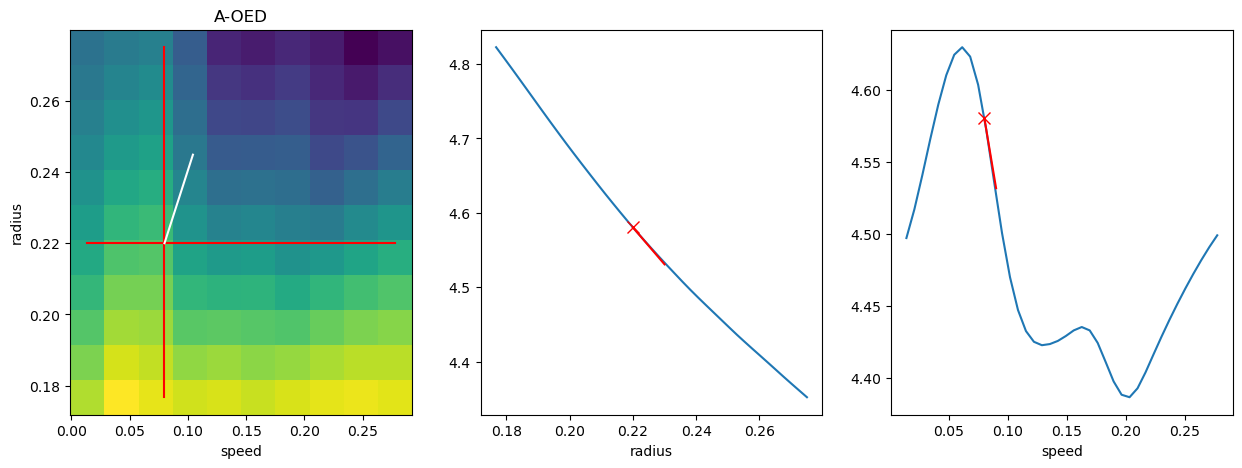

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
scale = 0.01
norm = la.norm(der_ref_A)

axs[0].pcolormesh(vec_speed_2d, vec_radius_2d, util[0, :, :])
axs[0].plot([vec_speed_2d[0], vec_speed_2d[-1]], [radius_test, radius_test], color="r", marker=None)
axs[0].plot([speed_test, speed_test], [vec_radius_2d[0], vec_radius_2d[-1]], color="r", marker=None)
axs[0].plot([speed_test, speed_test - 0.5 * scale * der_ref_A[1]], 
            [radius_test, radius_test - 0.5 * scale * der_ref_A[0]], 
            color = "w", marker = None)
axs[0].set_xlabel("speed")
axs[0].set_ylabel("radius")
axs[0].set_title("A-OED")

axs[1].plot(vec_radius, util_test[0, 1, :])
axs[1].plot([radius_test], util_ref[0], marker="x", markersize=8, color="r")
axs[1].plot([radius_test, radius_test + scale], 
            [util_ref[0], util_ref[0]+scale*der_ref_A[0]], 
            marker="", markersize=8, color="r")
axs[1].set_xlabel("radius")

axs[2].plot(vec_speed, util_test[0, 0, :-1])
axs[2].plot([speed_test], util_ref[0], marker="x", markersize=8, color="r")
axs[2].plot([speed_test, speed_test + scale], 
            [util_ref[0], util_ref[0]+scale*der_ref_A[1]], 
            marker="", markersize=8, color="r")
axs[2].set_xlabel("speed")

In the plot on the left, the sign for the gradient is chosen such that it points into the steepest decent direction.

Here's the plot for D-OED:

Text(0.5, 0, 'speed')

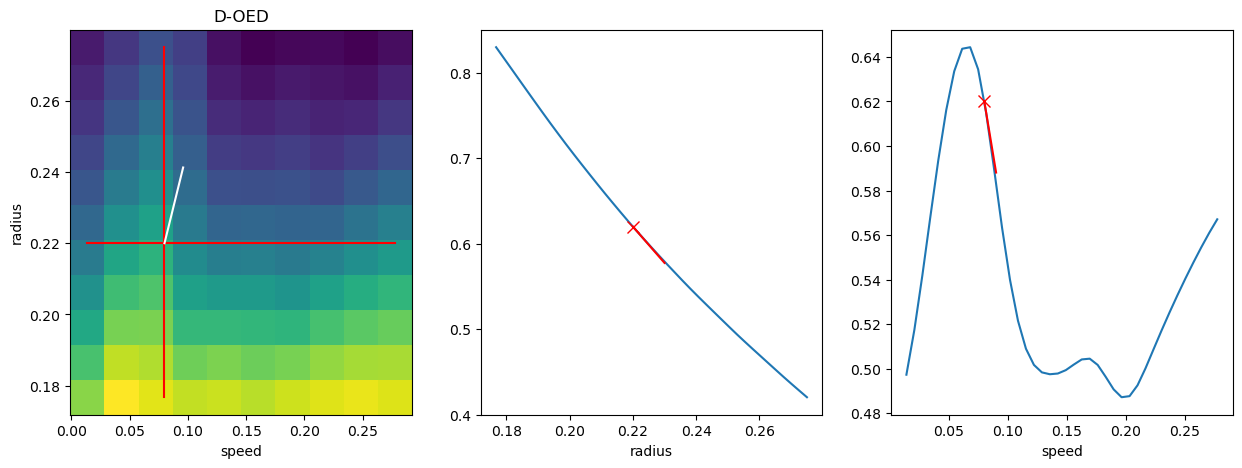

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
scale = 0.01
norm = la.norm(der_ref_D)

axs[0].pcolormesh(vec_speed_2d, vec_radius_2d, util[1, :, :])
axs[0].plot([vec_speed_2d[0], vec_speed_2d[-1]], [radius_test, radius_test], color="r", marker=None)
axs[0].plot([speed_test, speed_test], [vec_radius_2d[0], vec_radius_2d[-1]], color="r", marker=None)
axs[0].plot([speed_test, speed_test - 0.5 * scale * der_ref_D[1]], 
            [radius_test, radius_test - 0.5 * scale * der_ref_D[0]], 
            color = "w", marker = None)
axs[0].set_xlabel("speed")
axs[0].set_ylabel("radius")
axs[0].set_title("D-OED")

axs[1].plot(vec_radius, util_test[1, 1, :])
axs[1].plot([radius_test], util_ref[1], marker="x", markersize=8, color="r")
axs[1].plot([radius_test, radius_test + scale], 
            [util_ref[1], util_ref[1]+scale*der_ref_D[0]], 
            marker="", markersize=8, color="r")
axs[1].set_xlabel("radius")

axs[2].plot(vec_speed, util_test[1, 0, :-1])
axs[2].plot([speed_test], util_ref[1], marker="x", markersize=8, color="r")
axs[2].plot([speed_test, speed_test + scale], 
            [util_ref[1], util_ref[1]+scale*der_ref_D[1]], 
            marker="", markersize=8, color="r")
axs[2].set_xlabel("speed")

Instead of minimizing the D-OED criterion, we've also talked about maximizing its inverse, which can be computed more efficiently. In this case the sign for the derivative in the 2D plot was chosen to point into the steepest ascend direction.

Text(0.5, 0, 'speed')

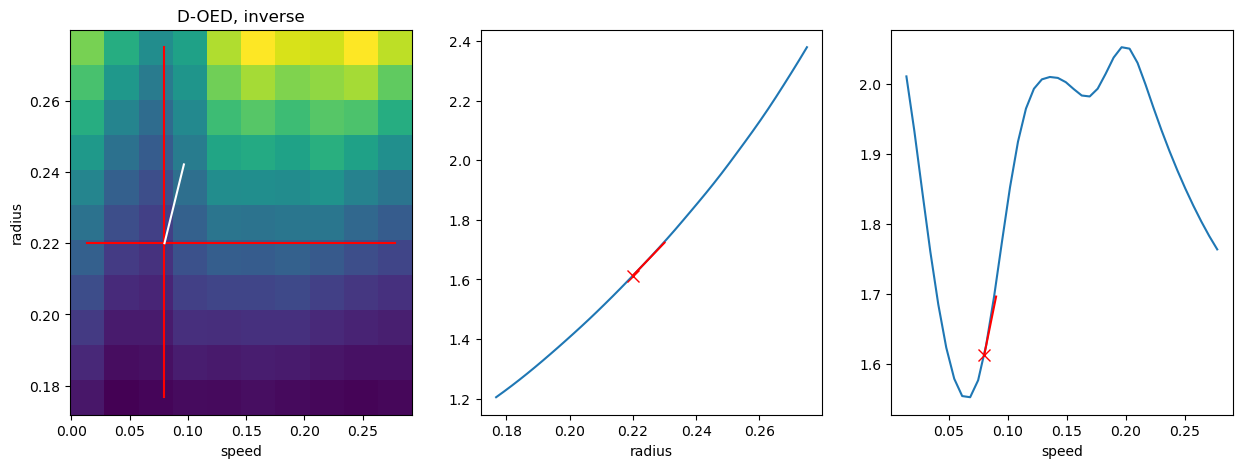

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
scale = 0.01
norm = la.norm(der_ref_D)

axs[0].pcolormesh(vec_speed_2d, vec_radius_2d, 1/util[1, :, :])
axs[0].plot([vec_speed_2d[0], vec_speed_2d[-1]], [radius_test, radius_test], color="r", marker=None)
axs[0].plot([speed_test, speed_test], [vec_radius_2d[0], vec_radius_2d[-1]], color="r", marker=None)
axs[0].plot([speed_test, speed_test + 0.2 * scale * der_ref_Dinv[1]], 
            [radius_test, radius_test + 0.2 * scale * der_ref_Dinv[0]], 
            color = "w", marker = None)
# positive gradient direction because we want to maximize

axs[0].set_xlabel("speed")
axs[0].set_ylabel("radius")
axs[0].set_title("D-OED, inverse")

axs[1].plot(vec_radius, util_test[2, 1, :])
axs[1].plot([radius_test], util_ref[2], marker="x", markersize=8, color="r")
axs[1].plot([radius_test, radius_test + scale], 
            [util_ref[2], util_ref[2]+scale*der_ref_Dinv[0]], 
            marker="", markersize=8, color="r")
axs[1].set_xlabel("radius")

axs[2].plot(vec_speed, util_test[2, 0, :-1])
axs[2].plot([speed_test], util_ref[2], marker="x", markersize=8, color="r")
axs[2].plot([speed_test, speed_test + scale], 
            [util_ref[2], util_ref[2]+scale*der_ref_Dinv[1]], 
            marker="", markersize=8, color="r")
axs[2].set_xlabel("speed")

## What's there:
- setup of the posterior
- utility function evaluation
- utility function derivatives for point-wise measurements (A, D, D-inverse OED)

I think this should be enough to get started on the optimization routine.

## What's missing?

- E-OED derivative
- parameter space reduction
- optimization of the code (don't use `la.inv`, make sure not to re-compute different values, get rid of some `for`-loops)

## The End.

In [32]:
runtime_notebook = time.time()-tStart_notebook
print("Runtime of this notebook: {} min".format(runtime_notebook / 60))

Runtime of this notebook: 6.257250046730041 min
